**The K-armed Dueling Bandits Problem**

Andrei Chubarau, 260581375, andrei.chubarau@mail.mcgill.ca

Bonnie Hu, 260556970, guanqing.hu@mail.mcgill.ca

Original algorithms presented in paper: https://www.cs.cornell.edu/people/tj/publications/yue_etal_09a.pdf

**Key results presented in the paper:**


*   **Problem modeling**: The paper proposes a novel bandit model that deals with the type of problems where only ***pairwise comparisons*** are possible, while absolute rewards have no natural scale or are difficult to measure (e.g. taste of food, product attractiveness). In the setting of multi-armed bandits, at each time step, two bandit arms are compared, and the better one is determined. As such, the aforementioned problem is termed the "Dueling Bandits Problem".
*   **Algorithm** Along with the definition of the problem, the paper proposes an algorithm to determine the best policy using an explore and exploit approach. A detailed analysis of the algorithm and its mathematical properties is provided, including proof of runtime complexity, bounds on overal accuracy, bounds on total regret, and more. In short, the algorithm explores the bandit problem by running duels on pairs of bandits and keeping track of the winners over time; the empyrical estimate of a bandit $b1$ winning over a bandit $b2$ is maintained by $P(b1,b2)$. By construct of the algorithm and the underlying mathematical properties, a confidence bound is also defined; the confidence bound estimates how certain the algorithm is in its estimate of $P(b1,b2)$. As exploration of bandits continues, better and better estimates are drawn, and the confidence bounds become more and more narrow. Eventually, the best policy can be drawn from the set of all bandits with enough certitude to warrant correctness.
*   **Regret and algorithm**: The paper successfully formulates an appropriate notion of regret for the dueling bandit problem and an algorithm that is able to optimize the regret bound. All in all, the defined algorithm is "information theoretically optimal up to constant factors", the proof of which is provided in the paper, and achieves low-regret especially when used in a setting with many bandits.
*   **Explore vs. exploit**: The proposed algorithm uses "explore then exploit" approach; the exploration is performed until the best action is found, whereafter an exploitation strategy is adopted using the best action. Two explore algorithms are presented: ***Interleaved Filter 1*** requiring $O(\frac{KlogK}{\epsilon_{1,2}}logT)$ and ***Interleaved Filter 2*** requiring $O(\frac{K}{\epsilon_{1,2}}logT)$. The total accumulated weak and strong regret bounds are proven to be bounded.
*   **Interleaved filter algorithm**: One special feature of the interleaved filter algorithm is that the number of experiments run on each bandit is non-uniform. A small set of bandits (O(logK)) participate in O(K) comparisons, while the rest of bandits only participates O(logK) comparisons. This feature makes the proposed algorithm an improvement over existing search algorithms based on noisy comparisons, where all bandits are explored in relative uniformity. Non-uniform search is desireable, because the amount of uncertainty over certain bandits may be higher than over others, thus their exploration is more crucial to acquiring an accurate result.


Below is our implementation of the presented algorithms, namely the Explore and Exploit strategy, including Interleaved Filter 1 and 2, as presented in the paper.

We run multiple experiments to measure various aspects of the algorithms' performance, namely the overal accuracy, the total regret, and the overal runtime.

In [0]:
'''
Algorithm Implementation 

'''
import matplotlib.pyplot as plt
import numpy as np

class DuelingBandits:
    def __init__(self, 
                 kArm=10, # number of bandit arms
                 T=1000, # input number of time steps
                 trueReward=0, # overall reward mean
                 max_time_steps = 1000000, # will stop exploring after this many comparisons to avoid running forever
                 InterleavedFilter = 1 # 1 for IF1 and 2 for IF2
                ):
    
        self.k = kArm
        self.trueReward = trueReward
        self.T = T
        self.max_time_steps = max_time_steps
        
        # initial real reward for each action based on a normal distribution
        self.armReward = []
        for i in range(0, self.k):
            self.armReward.append(np.random.randn() + trueReward)
            
        # find the best action 
        self.bestAction = np.argmax(self.armReward)
        # print("True values of action sets: ",self.armReward)
        
        # initial parameters required for EXPLORE algorithm
        self.sigma = 1/self.T/self.k**2
        
        # random pick the first action as b_hat, remove b_hat from action set W
        self.b_hat = np.random.randint(0,self.k)
        self.W = [b for b in range(self.k) if b!=self.b_hat]
        
        # initial winning probability P and confidence interval C, and comparison counter t
        self.P = [self.k*[0.5] for _ in range(self.k)]
        self.t = [self.k*[0] for _ in range(self.k)]
        self.C = [self.k*[[0,1]] for _ in range(self.k)]
        
        # initial step count
        self.step = 0
        
        # select Interval Filter 1 or 2
        self.filter = InterleavedFilter
        
        # regret
        self.total_regret_strong = 0
        self.total_regret_weak = 0

    # EXPLORE algorithm IF1 and IF2 as per the pseudocode provided in the paper
    def duelIF(self):
        t = 0
        while len(self.W)>0 and t < self.max_time_steps:
            for b in self.W:
                P1, P2 = self.P[self.b_hat][b], self.P[b][self.b_hat]
                t = self.t[self.b_hat][b]
                reward1 = np.random.randn() + self.armReward[self.b_hat]
                reward2 = np.random.randn() + self.armReward[b]
                self.step += 1
                if reward1 > reward2:
                    self.P[self.b_hat][b] = (P1 * t + 1)/(t + 1)
                    self.t[self.b_hat][b] += 1
                    self.P[b][self.b_hat] = (P2 * t)/(t + 1)
                    self.t[b][self.b_hat] += 1
                else:
                    self.P[self.b_hat][b] = (P1 * t) / (t + 1)
                    self.t[self.b_hat][b] += 1
                    self.P[b][self.b_hat] = (P2 * t + 1) / (t + 1)
                    self.t[b][self.b_hat] += 1
                c_t = np.sqrt(np.log(1 / self.sigma) / (t + 1))
                self.C[self.b_hat][b] = [self.P[self.b_hat][b] - c_t, self.P[self.b_hat][b] + c_t]
                self.C[b][self.b_hat] = [self.P[b][self.b_hat] - c_t, self.P[b][self.b_hat] + c_t]
                
                # -1 and -0.5 because P = Epsilon + 0.5
                self.total_regret_strong += self.P[self.bestAction][b] + self.P[self.bestAction][self.b_hat] - 1
                self.total_regret_weak += max(self.P[self.bestAction][b], self.P[self.bestAction][self.b_hat]) - 0.5

            for b in self.W:
                cc = self.C[self.b_hat][b]
                if (self.P[self.b_hat][b] > 0.5) and (not ((0.5 > cc[0]) and (0.5 < cc[1]))):
                    self.W = [x for x in self.W if x != b]
                if (self.P[self.b_hat][b] < 0.5) and (not ((0.5 > cc[0]) and (0.5 < cc[1]))):
                    # IF2: pruning
                    if self.filter==2:
                        for b in self.W:
                            if (self.P[self.b_hat][b] > 0.5):
                                self.W = [x for x in self.W if x != b]
                    # IF1 and IF2
                    self.b_hat = b
                    self.W = [x for x in self.W if x != b]


**Testing**

We want to run multiple tests and see how the algorithm performs on average.

In [0]:
'''
Testing method, with accuracy and histogram stats

'''
def test(T, tests, kArms, InterleavedFilter,
        num_t_buckets=10 # number of histogram buckets: buckets are [10^0, 10^1, 10^2, ..., 10^(num_t_buckets-1)]
        ):
    
    t_log10 = np.zeros(num_t_buckets, np.uint) # histogram of number of comparisons
    
    regretsStrong = []
    regretsWeak = []
    
    # run tests
    correct = 0 # stores how many results are correct
    for _ in range(0, tests):
        # set up a bandit game
        bandits = DuelingBandits(kArm=kArms, T=T, InterleavedFilter=InterleavedFilter)
        bandits.duelIF()

        # check results
        if bandits.bestAction == bandits.b_hat:
            correct += 1

        t_log10[int(np.log10(bandits.step)) % num_t_buckets] += 1

        # show the progress of testing (convenient to see how much was completed because the runtime is long)
        if _ % 10 == 0:
            print("\rRunning tests... Finished {}/{} iterations.".format(_, tests), end="")
            
        regretsStrong.append(bandits.total_regret_strong) 
        regretsWeak.append(bandits.total_regret_weak)

    print("\nFinished.")
    return correct, t_log10, (regretsStrong, regretsWeak)




**First: test on the 2 algorithms **

In [10]:
# test configuration
T = 1000 # max time step T
tests = 1000 # number of tests to run
kArms = 25 # number of bandits in each bandit game

results = {}

for InterleavedFilter in [1,2]:
  results[InterleavedFilter] = test(T, tests, kArms, InterleavedFilter)

Running tests... Finished 990/1000 iterations.
Finished.
Running tests... Finished 990/1000 iterations.
Finished.


Now we want to analyze the results.

Firstly, we compute the overall accuracy for IF1 and IF2. This will later be used to evaluate the authors' claims regarding the correctness of the EXPLORE algorithms.

In [11]:
for filtername, result in results.items(): 
  correct = result[0]
  print("Overall correctiness ratio of interleaved filter {}: {}/{}={}".format(filtername, correct, tests, correct/tests))

Overall correctiness ratio of interleaved filter 1: 982/1000=0.982
Overall correctiness ratio of interleaved filter 2: 991/1000=0.991


As can be seen in the output above, when the maximum step threshold is set to $10^6$, the accuracy of both algorithms achieve >98%.  

Secondly, we analyze the runtime. Since multiple tests are run and each of these returns a T value, a histogram can be generated showing the trend in performance of the IF1 algorithm. The histogram depicts the overall trend of the runtime of the Algorithm IF1, in terms of the number of iterations. This is valuable information, because, ideally, we'd like to minimize the total number of required iterations.

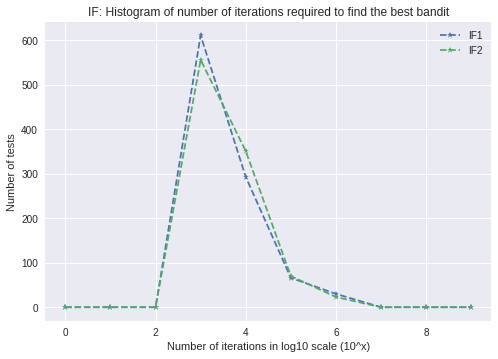

In [12]:
for filtername, result in results.items(): 
  t_log10 = result[1]
  plt.plot([i for i in range(len(t_log10))], t_log10, '*--', label='IF{}'.format(filtername))
  plt.ylabel('Number of tests')
  plt.xlabel('Number of iterations in log10 scale (10^x)')
  plt.title("IF: Histogram of number of iterations required to find the best bandit")
  plt.legend()
plt.show()

**Second test: Influence of input time steps T over algorithm performance**

The horizon time T has influence on the proposed algorithm. When the value of T is small, meaning time budget is tight, the threshold to exclude an action when it is loosing in a comparison decreases, making the explore faster. Experiments have been designed by running 100 tests for T values between $10^1$ and $10^6$. 

In [26]:
# test configuration
tests = 100 # number of tests to run
kArms = 25 # number of bandits in each bandit game
InterleavedFilter = 1

resultsT = {}

for T in [10, 100, 1000, 10000, 100000, 1000000]:
  resultsT[T] = test(T, tests, kArms, InterleavedFilter)

Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.


In [27]:
for T, result in resultsT.items(): 
  correct = result[0]
  print("Overall correctiness ratio of T={}: {}/{}={}".format(T, correct, tests, correct/tests))

Overall correctiness ratio of T=10: 100/100=1.0
Overall correctiness ratio of T=100: 99/100=0.99
Overall correctiness ratio of T=1000: 98/100=0.98
Overall correctiness ratio of T=10000: 100/100=1.0
Overall correctiness ratio of T=100000: 98/100=0.98
Overall correctiness ratio of T=1000000: 100/100=1.0


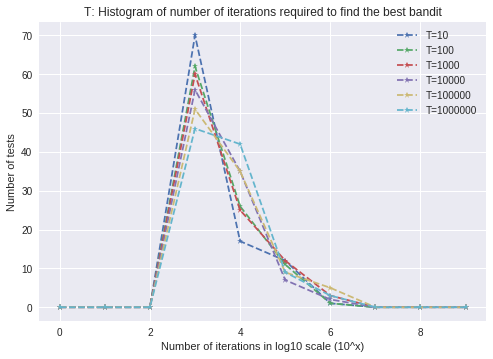

In [28]:
# plot total number of comparisons
for T, result in resultsT.items(): 
    t_log10 = result[1]
    plt.plot([i for i in range(len(t_log10))], t_log10, '*--', label='T={}'.format(T))
    plt.ylabel('Number of tests')
    plt.xlabel('Number of iterations in log10 scale (10^x)')
    plt.title("T: Histogram of number of iterations required to find the best bandit")
    plt.legend()
plt.show()

The accuracies of running with the six T values are similar, while the time efficiency are different as can be seen in the graph above. T=100 has the highest efficiency with the most tests whose explore finished within thousands of steps. When the step limit increases to $10^6$, **20%** of tests require 10 times more steps to finish exploring. When T is too small (e.g. T=10), however, the performance becomes worse because of the over-loose of the comparison limit.  

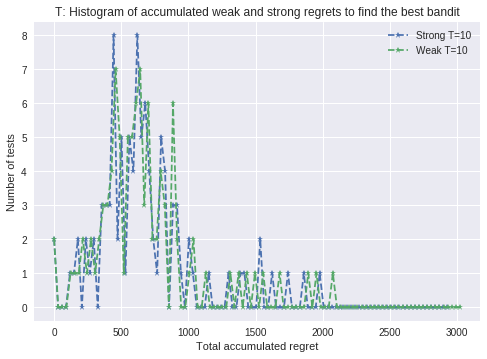

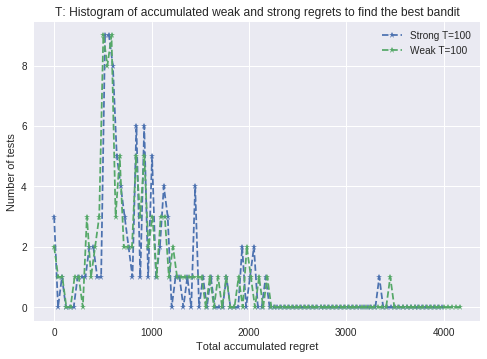

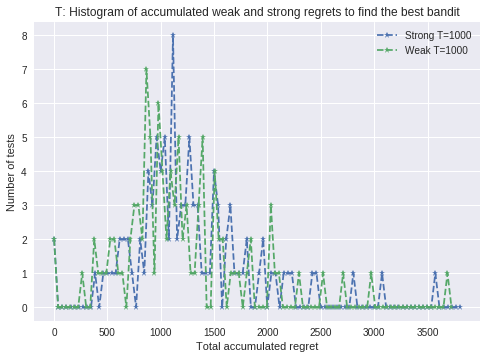

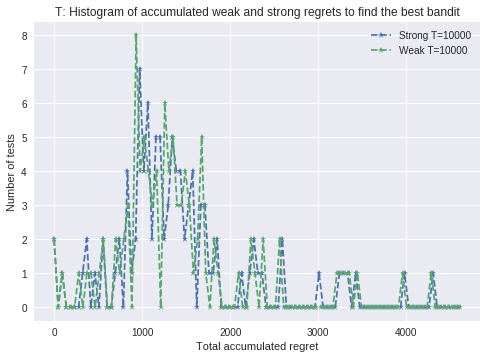

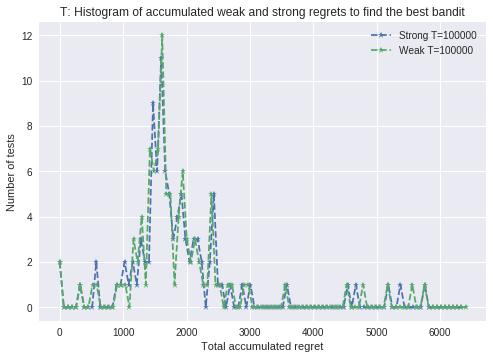

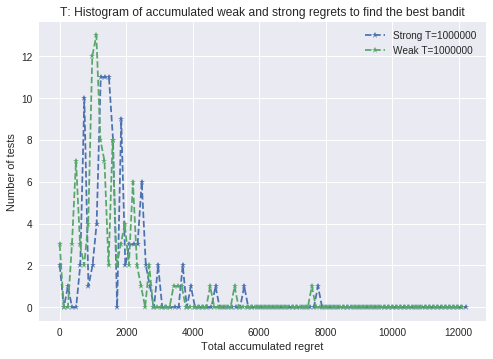

In [11]:
# plot accumulated regret
for T, result in resultsT.items(): 
    regretStrong = result[2][0]
    regretWeak = result[2][1]
    
    def regretHistogram(regrets, num_buckets=100):
        min = np.amin(regrets)
        max = np.amax(regrets)
        incr = (max - min) / num_buckets
        hist = [0 for i in range(num_buckets)]
        for regret in regrets:
            ind = int(np.abs(regret - min) / incr) % num_buckets
            hist[ind] += 1
        return hist, incr
    
    histStrong, incrStrong = regretHistogram(regretStrong)
    histWeak, incrWeak = regretHistogram(regretWeak)
    
    plt.plot([incrStrong*i for i in range(len(histStrong))], histStrong, '*--', label='Strong T={}'.format(T))
    plt.plot([incrWeak*i for i in range(len(histWeak))], histWeak, '*--', label='Weak T={}'.format(T))
    
    plt.ylabel('Number of tests')
    plt.xlabel('Total accumulated regret')
    plt.title("T: Histogram of accumulated weak and strong regrets to find the best bandit")
    plt.legend()
    plt.show()



As can be seen in the graphs above, total weak and strong regret values are quite similar; strong regret, both by its mathematical definition and our empyrical results, is higher than the weak regret.

According to our results, total regret is sensitive to the input value of time steps T: lower input T results in lower overal regret.

**Third test: Effect of number of arms**

The paper proposed that the number of arms does not influence the accuracy of the algorithm, only the number of steps (T) does. We will try to prove this with experiments. 

However, the number of arms should have influence on the steps required to finish explore. And the paper proved that the big O of IF2 algorithm is $O(\frac{K}{\epsilon_{1,2}}logT)$, where K is the number of arms. The experiments below will be used to check this relation as well. 

In [25]:
# test configuration
T = 100
tests = 100 # number of tests to run
InterleavedFilter = 2

resultsA2 = {}

for kArms in [10, 25, 40, 55, 70]:
  resultsA2[kArms] = test(T, tests, kArms, InterleavedFilter)
  

Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.
Running tests... Finished 90/100 iterations.
Finished.


In [32]:
for kArms, result in resultsA2.items(): 
  correct = result[0]
  print("Overall correctiness ratio of kArms={}: {}/{}={}".format(kArms, correct, tests, correct/tests))

Overall correctiness ratio of kArms=10: 100/100=1.0
Overall correctiness ratio of kArms=25: 99/100=0.99
Overall correctiness ratio of kArms=40: 99/100=0.99
Overall correctiness ratio of kArms=55: 98/100=0.98
Overall correctiness ratio of kArms=70: 98/100=0.98


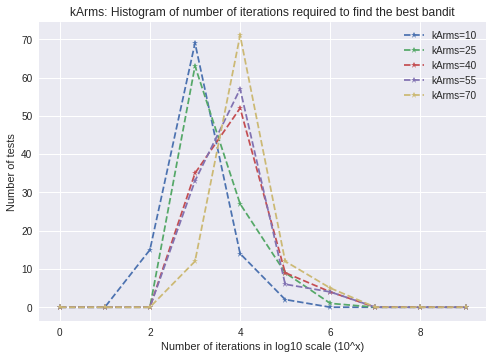

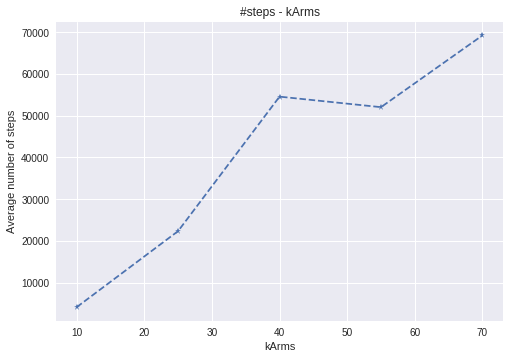

In [18]:
for kArms, result in resultsA2.items(): 
    t_log10 = result[1]
    plt.plot([i for i in range(len(t_log10))], t_log10, '*--', label='kArms={}'.format(kArms))
    plt.ylabel('Number of tests')
    plt.xlabel('Number of iterations in log10 scale (10^x)')
    plt.title("kArms: Histogram of number of iterations required to find the best bandit")
    plt.legend()
plt.show()
  
x = []
y = []
for kArms, result in resultsA2.items(): 
    t_log10 = result[1]
    x.append(kArms)
    average = sum([t_log10[i]*10**i for i in range(10)])/sum(t_log10)
    y.append(average)
plt.plot(x,y, '*--')
plt.ylabel('Average number of steps')
plt.xlabel('kArms')
plt.title("#steps - kArms")
plt.show()

As can be seen from the graph above, the relation between the number of arms and steps to explore is relatively linear which is as expected. 

** Conclusion **

The proposed definition of the Dueling Bandit problem is based on real world scenario where direct estimation of rewards is problematic, while a binary comparison between bandits is possible. The explored work provides an effective algorithm capable of solving the aforementioned problem and, when given enough time budget, to determine the best policy. The paper provides proof regarding the performance, the runtime, and multiple other multiple properties of the algorithm.

One of the weaknesses of exploration via sampling is that in the event of two bandits having near identical reward values, the algorithm will struggle to identify the winner; more evaluations will be required. While the Interleaved Filter attempts to compensate for this by exploring certain pairs of bandits more than others, the difficulty is still clearly observable: in some cases, the required number of evaluations far exceeds the input T. Usually, the overal runtime suffers tremendously when this is the case, and the actual number of required time steps *t* is in counted in the 1000s, while the limiting input T may be set lower. 

The input T time steps can be seen as the time budget given to the explore algorithm, however, the proposed algorithm does not provide a mechanism to stop exploration after a maximum number of steps T. This is a big limitation of the approach, because the actual number of time steps required for correct identification of the best policy often far exceeds the input T. Our implementation provides a stopping criterion to the algorithm, to avoid the apparent near "infinite" runtime which occurs in some cases.